#### Trisa Nguyen
#### October 17, 2022
#### ADTA 5560

# Final Project Part V (Redesign)

### PART I: Build, Train, and Test an LSTM with Time Series Data

### Import libraries

In [1]:
# Basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Time series RNN LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [3]:
# Keras:TimeseriesGenerator

# This class produces time series batches used on training/testing the model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Keras: MinMaxScaler
#This class is used to preprocess (scale) the data
from sklearn.preprocessing import MinMaxScaler

### Import Dataset: 

In [4]:
dir_path_dataset_1 = 'DELHI_01013_123116.csv'

### Load Dataset

In [5]:
df_ALL = pd.read_csv(dir_path_dataset_1)

In [6]:
df_ALL.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


### Exploratory Data Analysis

In [7]:
df_ALL.shape

(1462, 5)

In [8]:
df_ALL.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

In [9]:
# Summary statistics

df_ALL.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


#### Keep Only "Close" (for closing price) and Filter Out All Other Attributes
##### Note: The research focuses only on the closing price

In [10]:
df = df_ALL.iloc[:,1:2]

In [11]:
df.head()

,meantemp
0,10.000000
1,7.400000
2,7.166667
3,8.666667
4,6.000000


<AxesSubplot:>

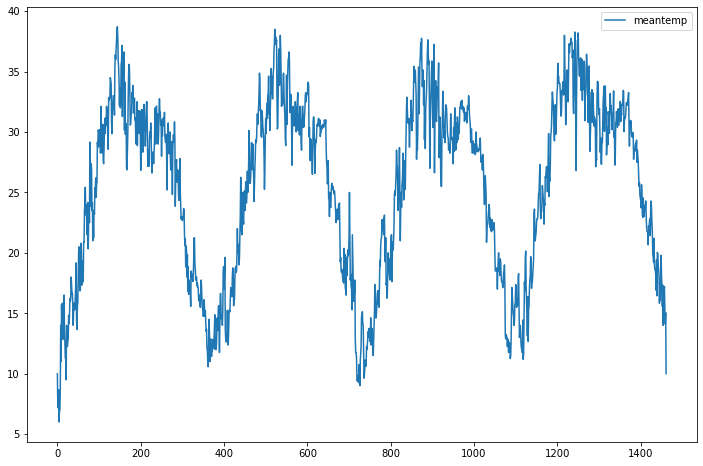

In [12]:
df.plot(figsize=(12, 8))

#### Length of Input Time Series - Number of Input Time Steps

In [13]:
# Set the length of the input sequence
# I.e the number of time series steps that are used to predict the future one
# Currently use 60 historical data points to predict the next one
# It means that 60 consecutive closing prices will be used to predict the next one.

length60 = 60

In [14]:
length60

60

### Time Series Dataset: Train/test split

In [15]:
len(df)

1462

In [16]:
# set percentage of data used for testing

test_percent = 0.1

In [17]:
# Number of data points reserved for testing the model
# 20% of the orignal dataset

len(df)*test_percent

146.20000000000002

#### Split data into Train/Test

In [18]:
# Need to find the length (number of data points) of the testing dataset
# It has been fond(above) that around 146 data points are used for testing

test_length = np.round(len(df)*test_percent)

test_length

146.0

In [19]:
# The testing data set starts at this index

# test_start_index = int(len(df)- test_length)
split_index = int(len(df) - test_length)

split_index

1316

In [20]:
# Create separate training / testing dataset

# Training dataset: All the indices from start to split_index
# Excluding split_index
data_train = df.iloc[:split_index]

# Testing dataset: All the indices from (split_index - length60) to the end of the dataframe
# Split_index - length60 needs the last 60 historical data points (belong to data_train)
# to predict the first data point of data_test
data_test = df.iloc[split_index - length60:]

In [21]:
data_train.head(5)

,meantemp
0,10.000000
1,7.400000
2,7.166667
3,8.666667
4,6.000000


In [22]:
data_train.tail(5)

,meantemp
1311,33.111111
1312,33.800000
1313,30.066667
1314,33.117647
1315,33.809524


In [23]:
data_test.head(5)

,meantemp
1256,36.133333
1257,33.437500
1258,35.500000
1259,36.000000
1260,32.625000


In [24]:
data_test.tail(5)

,meantemp
1457,17.217391
1458,15.238095
1459,14.095238
1460,15.052632
1461,10.000000


### Normalize Data (Scale it into the range [0,1])

In [25]:
# Create a MinMaxScaler to normalize the data
scaler = MinMaxScaler()

In [26]:
# Ignore the warning: Just convert the data to floats
# Only scale the training data - Do not scale testing data

# Train the scaler to perform the normalization
scaler.fit(data_train)

MinMaxScaler()

In [27]:
# Normalize the training dataset
normalized_train = scaler.transform(data_train)

# Normal;ize the testing dataset
normalized_test = scaler.transform(data_test)

### Create TimeseriesGenerator for Training

In [73]:
# TimeseriesGenerator: Generate time series batches for training/testing

# Set the length of the input sequence as above
# length60

# batch_size:Number of time series samples in each batch
# Sample: A single time series input that has 60 historical data points
batch_size32 = 32

# Create a TimeseriesGenerator for training: Train_tsGenerator
# This time series generator produces time series batches used to train the mode
# TimeseriesGenerator (input, outputs, length, batch_size)
# Normally: Inputs & outputs are the same dataset during training &testing/vaidation

train_tsGenerator60 = TimeseriesGenerator(normalized_train, normalized_train, length=length60, batch_size=batch_size32)

In [74]:
len(normalized_train)

1316

In [75]:
len(train_tsGenerator60)

40

In [76]:
# What does the first batch look like?
x,y = train_tsGenerator60[0]

In [77]:
print(x)

[[[0.12227074]
  [0.04279476]
  [0.0356623 ]
  ...
  [0.45240175]
  [0.41048035]
  [0.34643377]]

 [[0.04279476]
  [0.0356623 ]
  [0.08151383]
  ...
  [0.41048035]
  [0.34643377]
  [0.39737991]]

 [[0.0356623 ]
  [0.08151383]
  [0.        ]
  ...
  [0.34643377]
  [0.39737991]
  [0.40756914]]

 ...

 [[0.26637555]
  [0.31179039]
  [0.30567686]
  ...
  [0.50218341]
  [0.46615721]
  [0.5349345 ]]

 [[0.31179039]
  [0.30567686]
  [0.31441048]
  ...
  [0.46615721]
  [0.5349345 ]
  [0.52576419]]

 [[0.30567686]
  [0.31441048]
  [0.36681223]
  ...
  [0.5349345 ]
  [0.52576419]
  [0.59224891]]]


In [78]:
print(y)

[[0.39737991]
 [0.40756914]
 [0.35458515]
 [0.45469432]
 [0.45414847]
 [0.53275109]
 [0.55531295]
 [0.59388646]
 [0.52401747]
 [0.55021834]
 [0.5349345 ]
 [0.47379913]
 [0.4992722 ]
 [0.55531295]
 [0.43813683]
 [0.50946143]
 [0.53275109]
 [0.50436681]
 [0.70815138]
 [0.54512373]
 [0.58842795]
 [0.65338428]
 [0.6419214 ]
 [0.5349345 ]
 [0.55458515]
 [0.45851528]
 [0.50218341]
 [0.46615721]
 [0.5349345 ]
 [0.52576419]
 [0.59224891]
 [0.58588064]]


## Build, Train, and Test Model

In [79]:
# Set number of features
# Features: Attribute/variable of the data set - used as predictors

# Only using one feature: Close price
n_features =1

In [80]:
# Define model
model = Sequential()

# Add 1st LSTM Layer
# This layer has 125 LSTM cells
# Activation function: relu
# MUST: return_sequences= True
# --Because of multiple LSTM layers: The layers are stacked
# --Outputs = inputs of the next LTSM layer
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(length60, n_features)))

# Add 1st Dropout Layer
model.add(Dropout(0.3))

# Add 2nd LSTM layer
# MUST: return_sequences = True
# --Because of multiple LSTM layers: The layers are stacked
# --Outputs = inputs of the next LSTM layer
model.add(LSTM(50, activation='relu', return_sequences=True))

# Add 2nd Dropout Layer
model.add(Dropout(0.3))

# Add 3rd LSTM
model.add(LSTM(50, activation='relu', return_sequences=True))

# Add 3rd Dropout Layer
model.add(Dropout(0.3))

# Add 4th LSTM layer
model.add(LSTM(50, activation='relu'))

# Add FC layer for final prediction
model.add(Dense(1))


### Compile Model

In [81]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

### Train(Fit) Model Using fit_generator()

In [82]:
# Train the model

model.fit_generator(train_tsGenerator60, epochs=50)

Epoch 1/50


C:\Users\trisa\AppData\Local\Temp\ipykernel_7128\2907909120.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_tsGenerator60, epochs=50)


40/40 [==============================] - 4s 30ms/step - loss: 0.1558
Epoch 2/50
40/40 [==============================] - 1s 30ms/step - loss: 0.0276
Epoch 3/50
40/40 [==============================] - 1s 30ms/step - loss: 0.0219
Epoch 4/50
40/40 [==============================] - 1s 30ms/step - loss: 0.0167
Epoch 5/50
40/40 [==============================] - 1s 30ms/step - loss: 0.0137
Epoch 6/50
40/40 [==============================] - 1s 30ms/step - loss: 0.0131
Epoch 7/50
40/40 [==============================] - 1s 30ms/step - loss: 0.0127
Epoch 8/50
40/40 [==============================] - 1s 31ms/step - loss: 0.0144
Epoch 9/50
40/40 [==============================] - 1s 30ms/step - loss: 0.0142
Epoch 10/50
40/40 [==============================] - 1s 30ms/step - loss: 0.0135
Epoch 11/50
40/40 [==============================] - 1s 30ms/step - loss: 0.0153
Epoch 12/50
40/40 [==============================] - 1s 30ms/step - loss: 0.0124
Epoch 13/50
40/40 [=============================

### Visualize Model's Performance after training

In [83]:
loss_history_keys = model.history.history.keys()

#model.history.history is a dict
# 'loss' : its key
# 'loss':loss during training;
loss_history_keys

dict_keys(['loss'])

<AxesSubplot:>

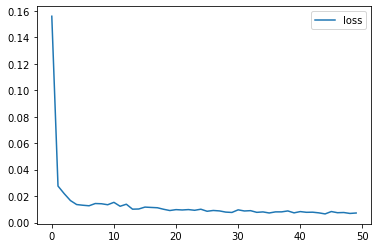

In [84]:
# Load the loss data (mode.history.history) into a dataframe
df_model_loss = pd.DataFrame(model.history.history)

#Visualize the loss data using DataFrame.plot()
df_model_loss.plot()

### Prediction for Testing: Using TimeseriesGenerator

#### Create TimeseriesGenerator for Testing

In [85]:
# batch_size must be 1
batch_size1 = 1

# Create a TimeseriesGenerator for testing: test_tsGenerator
test_tsGenerator60 = TimeseriesGenerator(normalized_test, normalized_test, length=length60, batch_size=batch_size1)

#### Predict Future Data Points for Test

In [86]:
normalized_prediction = model.predict_generator (test_tsGenerator60)

C:\Users\trisa\AppData\Local\Temp\ipykernel_7128\4281113417.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  normalized_prediction = model.predict_generator (test_tsGenerator60)


In [87]:
# Prediction is a numpy 2D array with only one column

normalized_prediction

array([[0.75232035],
       [0.7574998 ],
       [0.76322895],
       [0.76840866],
       [0.772268  ],
       [0.77460843],
       [0.77525824],
       [0.7747291 ],
       [0.77356285],
       [0.77197915],
       [0.7700872 ],
       [0.76833427],
       [0.7672665 ],
       [0.7670541 ],
       [0.76776   ],
       [0.76922196],
       [0.77097636],
       [0.7728119 ],
       [0.7745632 ],
       [0.7762217 ],
       [0.7780426 ],
       [0.77964187],
       [0.7806631 ],
       [0.7803555 ],
       [0.7781561 ],
       [0.7745736 ],
       [0.77036923],
       [0.76635444],
       [0.76300955],
       [0.7604611 ],
       [0.75879353],
       [0.75814575],
       [0.758339  ],
       [0.7592287 ],
       [0.76062155],
       [0.7624412 ],
       [0.76474893],
       [0.7673106 ],
       [0.77000034],
       [0.772668  ],
       [0.7753321 ],
       [0.7780211 ],
       [0.7807577 ],
       [0.78368056],
       [0.78686756],
       [0.7897791 ],
       [0.7920391 ],
       [0.793

In [88]:
len(normalized_prediction)

146

In [89]:
# Convert normalized predictions back to the true values

prediction = scaler.inverse_transform(normalized_prediction)

In [90]:
# Flatten all the 2D array

# data_train = data_train.reshape((-1))
# data_test = data_test.reshape((-1))
# prediction = prediction.reshapre ((-1))

prediction_index = np.arange(1316, 1462, step=1)

df_prediction = pd.DataFrame(data=prediction, index=prediction_index, columns=['Prediction'])

In [91]:
df_prediction

,Prediction
1316,30.611624
1317,30.781065
1318,30.968491
1319,31.137939
1320,31.264196
...,...
1457,17.489925
1458,17.311337
1459,17.135317
1460,16.930773


### Visualize Prediction

<AxesSubplot:>

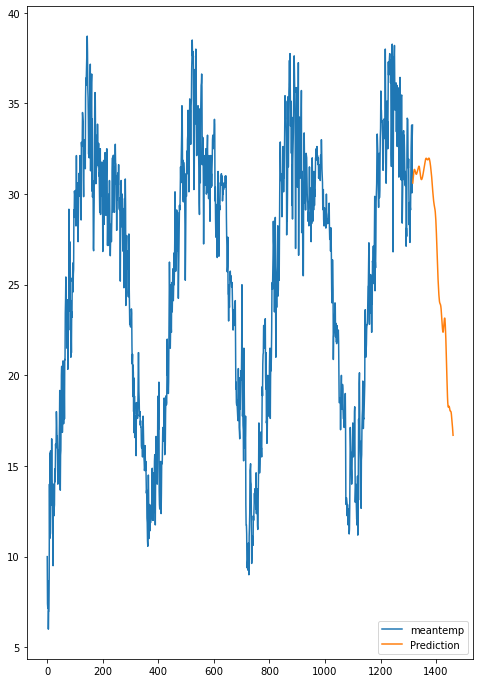

In [92]:
ax = data_train.plot()

df_prediction.plot(ax=ax, figsize=(8,12))

### Visualize Predction and Compare Actual Close Price

<AxesSubplot:>

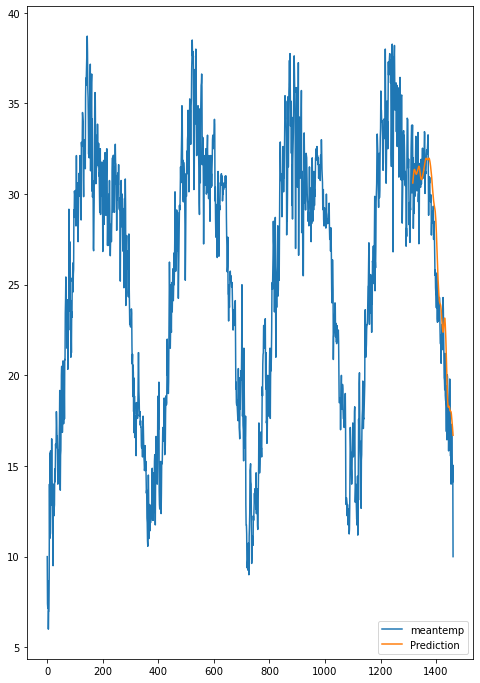

In [93]:
ax = df.plot()
df_prediction.plot( ax=ax, figsize=(8,12))

## Time Series Forecasting with LSTM

#### Overview

#### Time series forecasting:
#### - Forecasat into the "future" or unknown range
#### - Should employ all the available data
#### - i.e No splitting of the data into training/testing

#### Preprocess Full Input Dataset

In [94]:
# Still use MinMaxScaler to normalize the full input dataset df

full_scaler = MinMaxScaler()
normalized_full_data = full_scaler.fit_transform(df)

#### Create TimeSeriesGenerator for Forecasting

In [95]:
# Number of time strps of the input time series
# Still use length60:
length60

60

In [96]:
# Create Timeseries Generator for forecasting

forecast_tsGenerator = TimeseriesGenerator(normalized_full_data, normalized_full_data, length=length60, batch_size=batch_size32)

#### Build, Compile, and Fit LSTM Model for Forecasting

In [97]:
# Train/Fit LSTM model
# In forecasting, we don't validate, only FORECAST
# So, no need to EarlyStop, no need for validation_generator

model.fit_generator(forecast_tsGenerator, epochs = 30)

Epoch 1/30
 3/44 [=>............................] - ETA: 1s - loss: 0.0072

C:\Users\trisa\AppData\Local\Temp\ipykernel_7128\1768419428.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(forecast_tsGenerator, epochs = 30)


44/44 [==============================] - 2s 34ms/step - loss: 0.0066
Epoch 2/30
44/44 [==============================] - 1s 30ms/step - loss: 0.0076
Epoch 3/30
44/44 [==============================] - 1s 30ms/step - loss: 0.0073
Epoch 4/30
44/44 [==============================] - 1s 30ms/step - loss: 0.0070
Epoch 5/30
44/44 [==============================] - 1s 30ms/step - loss: 0.0062
Epoch 6/30
44/44 [==============================] - 1s 30ms/step - loss: 0.0063
Epoch 7/30
44/44 [==============================] - 1s 30ms/step - loss: 0.0066
Epoch 8/30
44/44 [==============================] - 1s 31ms/step - loss: 0.0061
Epoch 9/30
44/44 [==============================] - 1s 30ms/step - loss: 0.0064
Epoch 10/30
44/44 [==============================] - 1s 30ms/step - loss: 0.0078
Epoch 11/30
44/44 [==============================] - 1s 30ms/step - loss: 0.0072
Epoch 12/30
44/44 [==============================] - 1s 30ms/step - loss: 0.0082
Epoch 13/30
44/44 [=============================

#### Time Series Forecasting using LSTM Neural Network: 1/01/17 - 4/24/17

In [98]:
forecast = []

# Set periods with the time span of forecasting
# Let's forecast for the next 114 business days 1/01/17 - 4/24/17
periods = 114

first_eval_batch = normalized_full_data[-length60:]
current_batch = first_eval_batch.reshape((1, length60, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred)
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 14ms/step


#### Inverse to Transform Normalized Data Back into True Values

In [99]:
forecast = full_scaler.inverse_transform(forecast)

forecast

array([[15.88784891],
       [15.54290064],
       [15.25110338],
       [15.03795726],
       [14.90497736],
       [14.83958278],
       [14.82403312],
       [14.84142351],
       [14.87860562],
       [14.92662638],
       [14.9802327 ],
       [15.03691405],
       [15.09580369],
       [15.15696888],
       [15.22082497],
       [15.28777462],
       [15.35821463],
       [15.43248233],
       [15.51051437],
       [15.59202604],
       [15.67680286],
       [15.76481947],
       [15.85802484],
       [15.95868086],
       [16.0662435 ],
       [16.1807469 ],
       [16.30205456],
       [16.43048822],
       [16.56642127],
       [16.70955443],
       [16.85943431],
       [17.01631832],
       [17.1816845 ],
       [17.357279  ],
       [17.54364   ],
       [17.7414022 ],
       [17.95180186],
       [18.17609082],
       [18.41307769],
       [18.66116059],
       [18.91851343],
       [19.18413979],
       [19.45569782],
       [19.73111085],
       [20.01041202],
       [20

In [100]:
df

,meantemp
0,10.000000
1,7.400000
2,7.166667
3,8.666667
4,6.000000
...,...
1457,17.217391
1458,15.238095
1459,14.095238
1460,15.052632


#### Creating new timestamp index with pandas: 1/01/17 - 2/24/17

In [101]:
# calculate forecast index

forecast_index = np.arange(1462, 1576, step=1)

In [102]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Forecast'])

In [103]:
forecast_df

,Forecast
1462,15.887849
1463,15.542901
1464,15.251103
1465,15.037957
1466,14.904977
...,...
1571,34.449770
1572,34.464186
1573,34.476574
1574,34.487138


#### Plot the forecast

<AxesSubplot:>

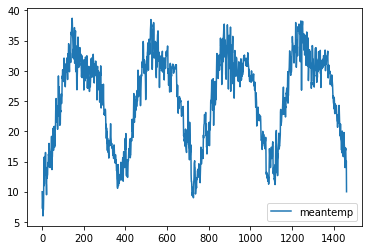

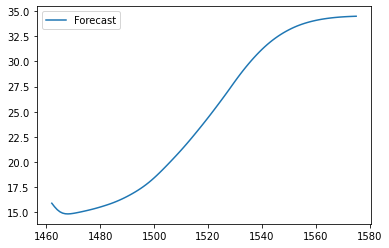

In [104]:
df.plot()
forecast_df.plot()

#### Joining Pandas Plots

<AxesSubplot:>

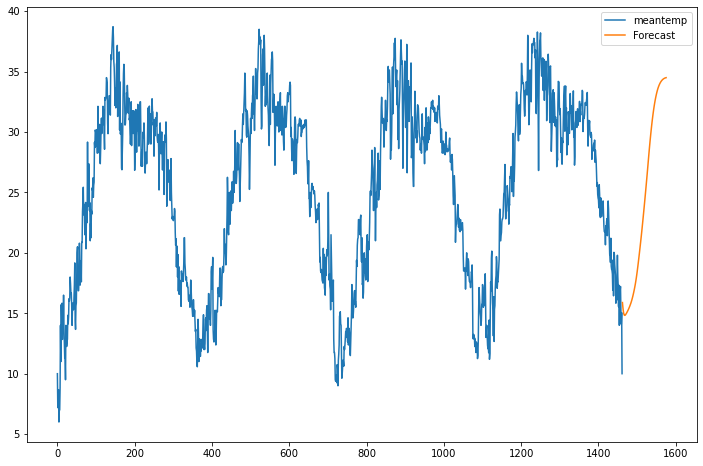

In [105]:
ax = df.plot()

forecast_df.plot(ax=ax, figsize=(12, 8))

In [106]:
dir_path_dataset_2 = 'DELHI_010117_042417.csv'

In [107]:
df_DELHI_2017 = pd.read_csv(dir_path_dataset_2)

In [108]:
df_DELHI_2017.tail()

,date,meantemp,humidity,wind_speed,meanpressure
109,2017-04-20,34.500,27.500000,5.562500,998.625000
110,2017-04-21,34.250,39.375000,6.962500,999.875000
111,2017-04-22,32.900,40.900000,8.890000,1001.600000
112,2017-04-23,32.875,27.500000,9.962500,1002.125000
113,2017-04-24,32.000,27.142857,12.157143,1004.142857


In [109]:
df_DELHI_2017 = df_DELHI_2017.iloc[:,1:2]

In [110]:
df_DELHI_2017

,meantemp
0,15.913043
1,18.500000
2,17.111111
3,18.700000
4,18.388889
...,...
109,34.500000
110,34.250000
111,32.900000
112,32.875000


<AxesSubplot:>

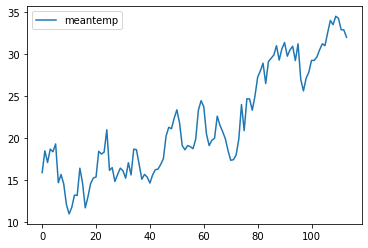

In [111]:
df_DELHI_2017.plot()

In [112]:
forecast_df['Forecast'].values

array([15.88784891, 15.54290064, 15.25110338, 15.03795726, 14.90497736,
       14.83958278, 14.82403312, 14.84142351, 14.87860562, 14.92662638,
       14.9802327 , 15.03691405, 15.09580369, 15.15696888, 15.22082497,
       15.28777462, 15.35821463, 15.43248233, 15.51051437, 15.59202604,
       15.67680286, 15.76481947, 15.85802484, 15.95868086, 16.0662435 ,
       16.1807469 , 16.30205456, 16.43048822, 16.56642127, 16.70955443,
       16.85943431, 17.01631832, 17.1816845 , 17.357279  , 17.54364   ,
       17.7414022 , 17.95180186, 18.17609082, 18.41307769, 18.66116059,
       18.91851343, 19.18413979, 19.45569782, 19.73111085, 20.01041202,
       20.29295104, 20.57900968, 20.86881801, 21.16417096, 21.46593818,
       21.77362536, 22.08687665, 22.40568035, 22.72978296, 23.05658622,
       23.38609793, 23.71935348, 24.05639774, 24.39724824, 24.74248413,
       25.09254997, 25.44644352, 25.80270427, 26.16190745, 26.52497733,
       26.89259639, 27.26502201, 27.64214109, 28.01592775, 28.38

In [113]:
df_DELHI_2017['Forecast'] = forecast_df['Forecast'].values

In [114]:
df_DELHI_2017

,meantemp,Forecast
0,15.913043,15.887849
1,18.500000,15.542901
2,17.111111,15.251103
3,18.700000,15.037957
4,18.388889,14.904977
...,...,...
109,34.500000,34.449770
110,34.250000,34.464186
111,32.900000,34.476574
112,32.875000,34.487138


<AxesSubplot:>

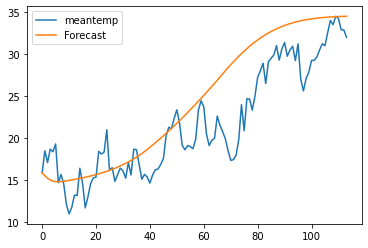

In [115]:
df_DELHI_2017.plot()